# Term Deposit Marketing

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

Import necessary libraries

In [1]:
import random
import numpy as np
import pandas as pd
# import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Data Description

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

Attributes:

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

- y - has the client subscribed to a term deposit? (binary)

In [2]:
df = pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Exploratory Data Analysis

This step investigate the following steps:
- Check for missing values
- Investigate the distribution of numerical variables
- Idenitfy number of categories in categorical features
- Compute the correlation between input and output variables

1. Check for missing value

In [4]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

This data set does not contain any missing values.

2. Investigate the distribution of numerical variables

In [5]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>, <Axes: >]], dtype=object)

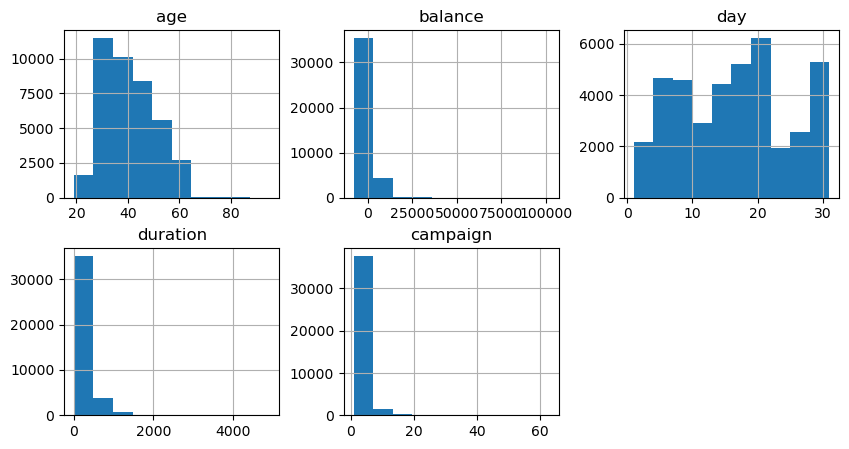

In [6]:
df.hist(figsize=(10, 5), layout=(2, 3))

The difference in range of numerical features is considerable. Standarization ('age' and 'day') might help increase the model accuracy. Other variables are positively skewed and has large outliers.

3. Idenitfy number of categories in categorical features

In [7]:
print('Number of unique values/Categories:')
for col in df.columns:
    print('- '+col+': ', df[col].nunique())

Number of unique values/Categories:
- age:  70
- job:  12
- marital:  3
- education:  4
- default:  2
- balance:  6849
- housing:  2
- loan:  2
- contact:  3
- day:  31
- month:  11
- duration:  1535
- campaign:  48
- y:  2


'education' and 'marital' are categorial object with 4 and 3 unique values, respectively.

In [8]:
df['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [9]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [10]:
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'default', 'housing', 'loan', 'contact'], drop_first=True, dtype=float)

In [11]:
df_dummies.head()

,age,education,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown
0,58,tertiary,2143,5,may,261,1,no,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,44,secondary,29,5,may,151,1,no,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,33,secondary,2,5,may,76,1,no,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,47,unknown,1506,5,may,92,1,no,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,33,unknown,1,5,may,198,1,no,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [12]:
education_dict = {'tertiary': 3, 'secondary': 2, 'unknown': 0, 'primary': 1}
df_dummies['ordinal_education'] = df_dummies.education.map(education_dict)
df_dummies = df_dummies.drop('education', axis=1)
df_dummies.head()

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,...,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
0,58,2143,5,may,261,1,no,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
1,44,29,5,may,151,1,no,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
2,33,2,5,may,76,1,no,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2
3,47,1506,5,may,92,1,no,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,33,1,5,may,198,1,no,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [13]:
cat_columns = df_dummies.select_dtypes(['object']).columns
cat_columns

Index(['month', 'y'], dtype='object')

In [14]:
df_dummies[cat_columns] = df_dummies[cat_columns].apply(lambda x: pd.factorize(x)[0])
df_dummies.head()

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,...,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
0,58,2143,5,0,261,1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
1,44,29,5,0,151,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
2,33,2,5,0,76,1,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2
3,47,1506,5,0,92,1,0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,33,1,5,0,198,1,0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


4. Compute the correlation between input and output variables 

In [15]:
df_dummies.corr().style.background_gradient(cmap='coolwarm')

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
age,1.000000,0.081517,-0.011689,0.022965,-0.036270,0.016204,-0.020273,-0.028956,0.027956,0.084920,-0.005302,0.333164,0.001712,-0.057227,-0.155146,-0.058308,0.008052,0.043904,0.265630,-0.408589,-0.014857,-0.179606,0.000041,0.120689,0.010386,-0.161471
balance,0.081517,1.000000,0.011662,0.059003,0.014072,-0.008137,0.030232,-0.041461,0.011692,0.003044,0.072172,0.015917,0.015771,-0.033618,0.000575,-0.012655,0.010020,0.010672,0.023683,-0.007168,-0.070069,-0.049946,-0.080596,0.029116,-0.018851,0.052765
day,-0.011689,0.011662,1.000000,0.029379,-0.032983,0.165429,-0.006420,-0.035006,-0.003629,0.005355,0.026526,-0.002787,0.005080,-0.009461,-0.011183,0.031902,-0.005475,-0.009526,0.005243,-0.002806,0.006287,-0.050622,0.005838,0.037242,-0.054363,0.032272
month,0.022965,0.059003,0.029379,1.000000,0.015157,-0.069674,0.106168,-0.096244,0.000201,-0.004050,0.057380,0.022085,0.020090,-0.031792,0.032897,0.017347,0.061696,-0.003019,-0.011074,0.024891,-0.024357,-0.167039,-0.014806,0.077645,-0.506906,0.085241
duration,-0.036270,0.014072,-0.032983,0.015157,1.000000,-0.088387,0.461169,0.015951,0.000247,-0.007239,-0.010846,0.001675,0.008821,0.003569,-0.007175,-0.008469,0.017896,-0.007971,-0.029153,0.026703,-0.008597,0.022455,-0.003952,-0.040379,0.001928,0.004813
campaign,0.016204,-0.008137,0.165429,-0.069674,-0.088387,1.000000,-0.040350,-0.004635,-0.002619,0.002804,0.021105,-0.013881,0.004581,-0.010404,-0.008503,0.018915,-0.017052,0.017037,0.027962,-0.016179,0.012135,-0.054823,0.000582,0.061620,-0.012468,0.006220
y,-0.020273,0.030232,-0.006420,0.106168,0.461169,-0.040350,1.000000,-0.032859,-0.007191,-0.015248,0.020291,0.024343,0.005029,-0.014645,0.037384,0.000234,0.009463,-0.000018,-0.056863,0.051721,-0.006559,-0.054336,-0.031029,-0.000842,-0.088408,0.043828
job_blue-collar,-0.028956,-0.041461,-0.035006,-0.096244,0.015951,-0.004635,-0.032859,1.000000,-0.105624,-0.092525,-0.280381,-0.106864,-0.105974,-0.182215,-0.063781,-0.251692,-0.093266,-0.042557,0.125618,-0.087522,0.004706,0.156122,0.005674,0.006448,0.116781,-0.374273
job_entrepreneur,0.027956,0.011692,-0.003629,0.000201,0.000247,-0.002619,-0.007191,-0.105624,1.000000,-0.031889,-0.096634,-0.036831,-0.036524,-0.062801,-0.021982,-0.086747,-0.032144,-0.014667,0.044941,-0.048960,0.025645,0.003303,0.038244,-0.006114,-0.002439,0.045729
job_housemaid,0.084920,0.003044,0.005355,-0.004050,-0.007239,0.002804,-0.015248,-0.092525,-0.031889,1.000000,-0.084650,-0.032263,-0.031995,-0.055013,-0.019256,-0.075988,-0.028158,-0.012848,0.046431,-0.061803,0.000017,-0.086038,-0.016788,0.037439,-0.003592,-0.108081


- Input feature 'duration' has 0.461 correlation to output variable 'y'. This is expected as longer call duration can signify that customer is interested and might end up subscribing.

- 'job_management' and 'ordinal_education' has correlation 0.455.

- 'job_retired' and 'age' has correlation value 0.33.

## Training

In [16]:
scaler = StandardScaler().set_output(transform="pandas")

In [17]:
X = df_dummies.loc[:, ~df_dummies.columns.isin(['y'])]
y = df_dummies['y']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [19]:
X_train.describe(), X_test.describe()

(                age       balance           day         month      duration  \
 count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
 mean      40.550967   1279.623333     16.033633      2.693300    254.304167   
 std        9.656658   2885.375365      8.288091      3.066814    257.121021   
 min       19.000000  -4057.000000      1.000000      0.000000      0.000000   
 25%       33.000000     55.000000      8.000000      0.000000    100.000000   
 50%       39.000000    409.000000     17.000000      2.000000    175.000000   
 75%       48.000000   1314.000000     21.000000      5.000000    313.000000   
 max       95.000000  98417.000000     31.000000     10.000000   4918.000000   
 
            campaign  job_blue-collar  job_entrepreneur  job_housemaid  \
 count  30000.000000     30000.000000      30000.000000   30000.000000   
 mean       2.873200         0.233367          0.035733       0.027667   
 std        3.212683         0.422981          0.185628 

In [20]:
scaler = StandardScaler().set_output(transform="pandas")
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train.describe(), scaled_X_test.describe()

(                age       balance           day         month      duration  \
 count  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04   
 mean  -7.555438e-17  4.926430e-17 -1.241081e-16  5.163277e-17 -2.960595e-17   
 std    1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00   
 min   -2.231758e+00 -1.849573e+00 -1.813914e+00 -8.782224e-01 -9.890611e-01   
 25%   -7.819571e-01 -4.244313e-01 -9.693145e-01 -8.782224e-01 -6.001327e-01   
 50%   -1.606138e-01 -3.017416e-01  1.165990e-01 -2.260690e-01 -3.084364e-01   
 75%    7.714012e-01  1.191430e-02  5.992272e-01  7.521612e-01  2.282848e-01   
 max    5.638591e+00  3.366598e+01  1.805798e+00  2.382545e+00  1.813844e+01   
 
            campaign  job_blue-collar  job_entrepreneur  job_housemaid  \
 count  3.000000e+04     3.000000e+04      3.000000e+04   3.000000e+04   
 mean  -6.536993e-17    -5.115908e-17     -9.473903e-18  -1.444770e-17   
 std    1.000017e+00     1.000017e+00      1.000017e+00 

In [21]:
logisticRegr = LogisticRegression(class_weight='balanced')
logisticRegr.fit(scaled_X_train, y_train)
y_pred = logisticRegr.predict(scaled_X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8425


In [22]:
logisticRegr.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

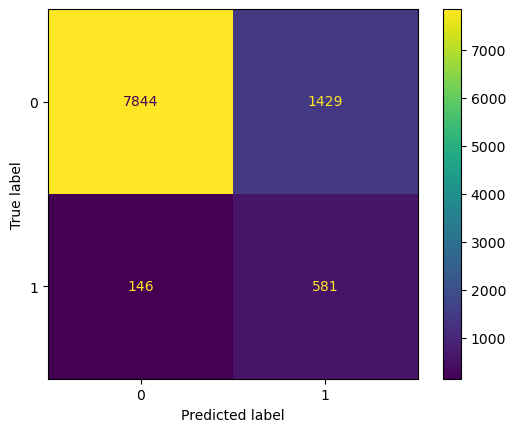

In [23]:
# Generate predictions with the best model
y_pred = logisticRegr.predict(scaled_X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Roc Auc:", roc_auc)

Accuracy: 0.8425
Precision: 0.2890547263681592
Recall: 0.7991746905089409
Roc Auc: 0.8225356899110002


### CV Grid Search

In [25]:
param_dist = {'C': [x/5 for x in range(1, 51, 2)]}
logisticRegr = LogisticRegression(class_weight='balanced', max_iter=1000)

# Use random search to find the best hyperparameters
cv_search = GridSearchCV(logisticRegr, param_grid = param_dist, cv=5, scoring='roc_auc')

# Fit the random search object to the data
cv_search.fit(scaled_X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             param_grid={'C': [0.2, 0.6, 1.0, 1.4, 1.8, 2.2, 2.6, 3.0, 3.4, 3.8,
                               4.2, 4.6, 5.0, 5.4, 5.8, 6.2, 6.6, 7.0, 7.4, 7.8,
                               8.2, 8.6, 9.0, 9.4, 9.8]},
             scoring='roc_auc')

In [26]:
# Create a variable for the best model
best_lr = cv_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  cv_search.best_params_)

Best hyperparameters: {'C': 0.6}


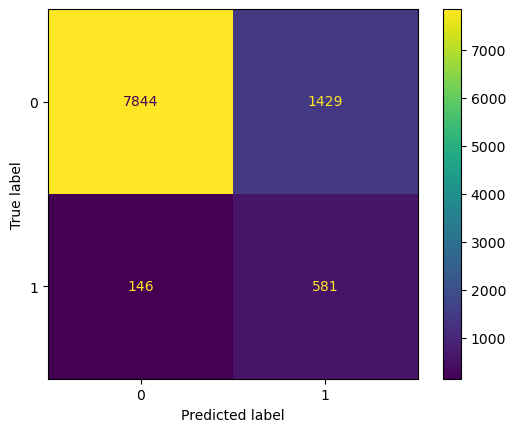

In [27]:
# Generate predictions with the best model
y_pred = best_lr.predict(scaled_X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [28]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Roc Auc:", roc_auc)

Accuracy: 0.8425
Precision: 0.2890547263681592
Recall: 0.7991746905089409
Roc Auc: 0.8225356899110002


## SMOTE (Synthetic Minority OverSampling Technique)

In [29]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
print(imblearn.__version__)

0.11.0


In [30]:
model = LogisticRegression(max_iter=1000)
over = SMOTE(k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [31]:
param_dist = {'over__sampling_strategy': [x/10 for x in range(1, 8)], 'model__C': [x/5 for x in range(1, 51, 2)]}

# Use random search to find the best hyperparameters
cv_search = GridSearchCV(pipeline, param_grid = param_dist, cv=5, scoring='roc_auc')
cv_search.fit(X_train, y_train)

# cv = GridSearchCV(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X_train, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# score = mean(scores)
# print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
250 fits failed out of a total of 875.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/imblearn/pi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'model__C': [0.2, 0.6, 1.0, 1.4, 1.8, 2.2, 2.6, 3.0,
                                      3.4, 3.8, 4.2, 4.6, 5.0, 5.4, 5.8, 6.2,
                                      6.6, 7.0, 7.4, 7.8, 8.2, 8.6, 9.0, 9.4,
                                      9.8],
                         'over__sampling_strategy': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                     0.6, 0.7]},
             scoring='roc_auc')

In [32]:
# Create a variable for the best model
best_lr = cv_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  cv_search.best_params_)

Best hyperparameters: {'model__C': 1.4, 'over__sampling_strategy': 0.1}


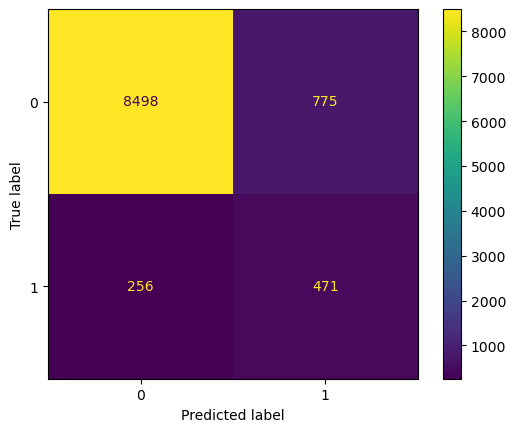

In [33]:
# Generate predictions with the best model
y_pred = best_lr.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [34]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Roc Auc:", roc_auc)

Accuracy: 0.8969
Precision: 0.3780096308186196
Recall: 0.6478679504814305
Roc Auc: 0.782145988612871


## SMOTE on Scaled Samples

In [35]:
model = LogisticRegression(max_iter=1000)
over = SMOTE(k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [37]:
param_dist = {'over__sampling_strategy': [x/10 for x in range(1, 4)], 'model__C': [x/5 for x in range(1, 51, 2)]}

# Use random search to find the best hyperparameters
cv_search = GridSearchCV(pipeline, param_grid = param_dist, cv=5, scoring='roc_auc')
cv_search.fit(scaled_X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'model__C': [0.2, 0.6, 1.0, 1.4, 1.8, 2.2, 2.6, 3.0,
                                      3.4, 3.8, 4.2, 4.6, 5.0, 5.4, 5.8, 6.2,
                                      6.6, 7.0, 7.4, 7.8, 8.2, 8.6, 9.0, 9.4,
                                      9.8],
                         'over__sampling_strategy': [0.1, 0.2, 0.3]},
             scoring='roc_auc')

In [38]:
# Create a variable for the best model
best_lr = cv_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  cv_search.best_params_)

Best hyperparameters: {'model__C': 9.0, 'over__sampling_strategy': 0.1}


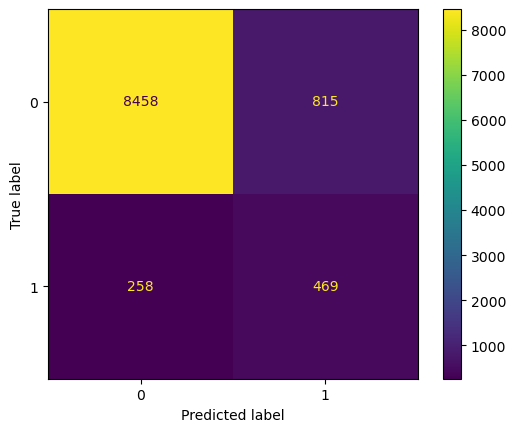

In [39]:
# Generate predictions with the best model
y_pred = best_lr.predict(scaled_X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [40]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Roc Auc:", roc_auc)

Accuracy: 0.8927
Precision: 0.3652647975077882
Recall: 0.6451169188445667
Roc Auc: 0.7786136734846149
